This is a simple example on how you can use a jupyter notebook to train your model :) 

In [59]:
import torch
import torch.nn as nn
from dataloaders import load_cifar10
from trainer import Trainer, compute_loss_and_accuracy
from task3 import create_plots, create_comparison_plots
from torchvision import transforms

In [60]:
class Banana(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # (Task  2a)
        num_filters = [image_channels, 32, 64, 128, 256]# Set number of filters in first conv layer
        num_layers = len(num_filters)-1
        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential(
            # Layer 1
            nn.Conv2d(
                in_channels=num_filters[0],
                out_channels=num_filters[1],
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters[1]),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),

            # Layer 2
            nn.Conv2d(
                in_channels=num_filters[1],
                out_channels=num_filters[2],
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.BatchNorm2d(num_filters[2]),

            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),


            # Layer 3
            nn.Conv2d(
                in_channels=num_filters[2],
                out_channels=num_filters[3],
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters[3]),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),

            
            # Layer 4
            nn.Conv2d(
                in_channels=num_filters[3],
                out_channels=num_filters[4],
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters[4]),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),

        )
        # The output of feature_extractor will be [batch_size, num_filters[-1], 4, 4]
        num_layers = len(num_filters)-1
        img_size = 32/(2**num_layers)
        self.num_output_features = round(num_filters[-1]*img_size**2)
        # Initialize predictions, 1 for each class.
        # There is no need for sr last fully connected layer
        # Inputs: all extracted features from the convolutional layers
        # Outputs: num_classes preoftmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.num_output_features, 64),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # (Task  2a)
        batch_size = x.shape[0]
        features = self.feature_extractor(x)
        # print("Features shape: " +str(features.shape))
        out = self.classifier(features)
        # print("Out shape: " +str(out.shape))

        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


In [61]:
epochs = 10
batch_size = 64
# learning_rate = 1e-2 # Should be 5e-5 for LeNet
learning_rate = 1e-3
momentum = 0.9
early_stop_count = 4
# imgTransform = transforms.Compose([
#             transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),

#             transforms.ToTensor(),
#             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         ])
imgTransform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
dataloaders = load_cifar10(batch_size,
                    imgTransform,
)
model = Banana(image_channels=3, num_classes=10)

trainer = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model,
    dataloaders,
)

trainer.optimizer = torch.optim.Adam(model.parameters(),
                                    )
trainer.train()

Files already downloaded and verified
Files already downloaded and verified
Banana(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout2d(p=0.1, inplace=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3

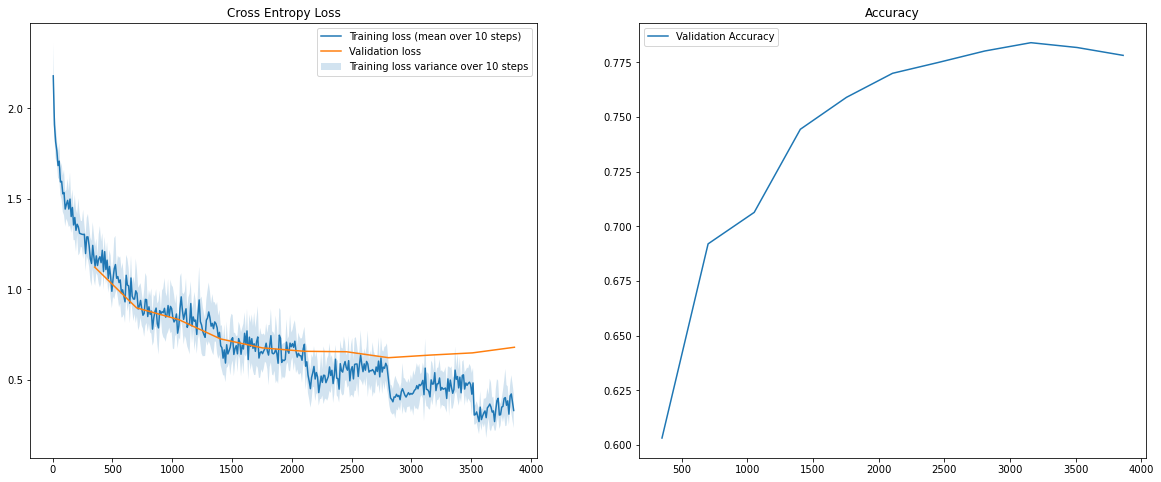

In [ ]:
create_plots(trainer, "task3_model2")

In [ ]:

# dataloaders = [dataloader_train, dataloader_val, dataloader_test]
final_train_loss , final_train_accuracy = compute_loss_and_accuracy(dataloaders[0], trainer.model, trainer.loss_criterion)
final_val_loss , final_val_accuracy = compute_loss_and_accuracy(dataloaders[1], trainer.model, trainer.loss_criterion)
final_test_loss , final_test_accuracy = compute_loss_and_accuracy(dataloaders[2], trainer.model, trainer.loss_criterion)

print("Train Accuracy: " + str(final_train_accuracy))
print("Test Accuracy: " + str(final_test_accuracy))
print("Validation Accuracy: " + str(final_val_accuracy))

print("Train Loss: " + str(final_train_loss))
print("Test Loss: " + str(final_test_loss))
print("Validation Loss: " + str(final_val_loss))



Train Accuracy: 0.8897137268847796
Test Accuracy: 0.753
Validation Accuracy: 0.7536
Train Loss: 0.3243910984625009
Test Loss: 0.8073179290932455
Validation Loss: 0.7838401266291172
